## Spam Score from SMSSPAMCOLLECTION applied to original dataset

Spam filtering is one of the most common uses to Natural Language Processing. It is used to classify emails and text messages as spam. In this notebook we use spam filtering technique to predict a spam score for the piece of news from our dataset.

In [2]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA
# WATCH THE VIDEO FOR FULL INSTRUCTIONS ON THIS STEP

# Uncomment the code below and run:


#!conda install nltk #This installs nltk
#import nltk # Imports the library
#nltk.download() #Download the necessary datasets

In [1]:
"""
Created on Tue Nov 18 16:54:40 2018

@author: gpandey
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl    
import pandas as pd

Link to dataset at UCI: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

This dataset contains over 5000 messages. Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages

In [3]:
messages = [line.rstrip() for line in open('../dataset/SMSSpamCollection')]
print(len(messages))

5574


A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using **enumerate**:

In [4]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

Due to the spacing we can tell that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

From the official SciKit Learn documentation, we can visualize our process:

<img src='http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/_images/plot_ML_flow_chart_1.png' width=600/>

Instead of parsing TSV manually using Python, we can just take advantage of pandas!

In [7]:
messages = pd.read_csv('../dataset/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [8]:
messages.describe()

label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [7]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better our domain knowledge on the data, the better our ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. 

Let's make a new column to detect how long the text messages are:

In [11]:
messages['length'] = messages['message'].apply(len)
messages.head()

label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61

### Data Visualization
Let's visualize this! Let's do the imports:

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

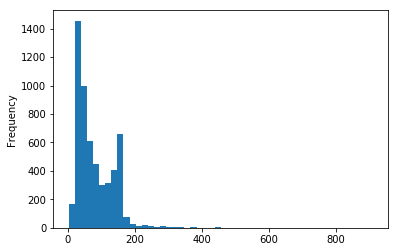

In [13]:
messages['length'].plot(bins=50, kind='hist') 

Play around with the bin size! Looks like text length may be a good feature to think about! Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [14]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [15]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b5facf8>,
      dtype=object)

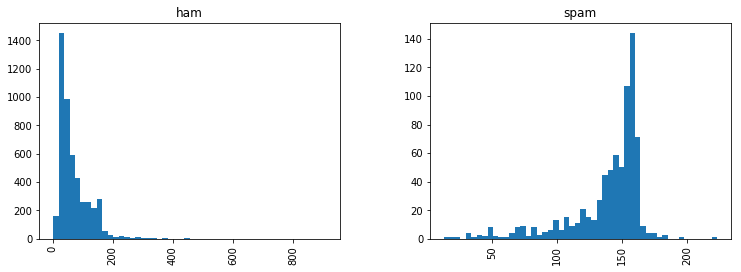

In [16]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

## Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

* First removing punctuation. 
* Remove Stopwords
* Return a list of clean text

In [23]:
import string
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [24]:
messages.head()

label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61

Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

**Note:**
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)

In [25]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [28]:
messages_bow = bow_transformer.transform(messages['message'])

In [29]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [30]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [33]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


In [34]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

In [36]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

## Part 6: Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [39]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [42]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



In the above "evaluation",we evaluated accuracy on the same data we used for training. 

## Train Test Split

In [44]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [45]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [46]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x1a1d88a730>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [47]:
predictions = pipeline.predict(msg_test)

In [48]:
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1014
       spam       0.69      1.00      0.82       101

avg / total       0.97      0.96      0.96      1115



## Customizing the spam model to our original dataset

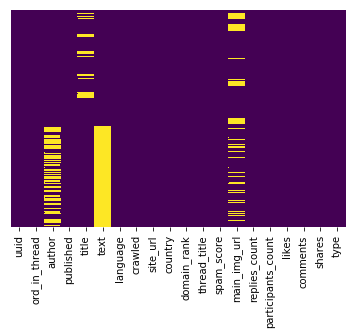

In [50]:
df = pd.read_csv('../dataset/fake_real_dataset.csv')
#df['content'] = df['title'] + df['text']
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')


In [51]:
def combine_column(tuple1):
    if(pd.notna(tuple1[1])):
        if(tuple1[1].strip(' \t\n\r') == ''):
            return 'NA spam'
        else:
            return tuple1[1]
    elif(pd.notna(tuple1[0])):
        if(tuple1[0].strip(' \t\n\r') == ''):
            return 'NA spam'
        else:
            return tuple1[0]   
    else:
            return 'NA spam'

In [52]:
#df.describe() 
#df['content'].describe() 
    #print(text)
df['content'] = df[['title', 'text']].apply(combine_column, axis=1)
#df['content1'] = df[['title', 'text']].apply(lambda x: ' '.join(x), axis=1)
df.head()
#dataset.shape()
output1 = pipeline.predict_proba(df['content'])

df['spam-score'] = output1[:,0]

In [54]:
df[['spam-score','content']].head(10)

spam-score                                            content
0    0.992326  Print They should pay all the back all the mon...
1    0.819090  Why Did Attorney General Loretta Lynch Plead T...
2    0.997706  Red State : \r\nFox News Sunday reported this ...
3    0.990487  Email Kayla Mueller was a prisoner and torture...
4    0.978483  Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...
5    0.978048  Print Hillary goes absolutely berserk! She exp...
6    0.999586  BREAKING! NYPD Ready To Make Arrests In Weiner...
7    0.967232  BREAKING! NYPD Ready To Make Arrests In Weiner...
8    0.978259  \r\nLimbaugh said that the revelations in the ...
9    0.976876  Email \r\nThese people are sick and evil. They...

### LDA with Count Vectorizer

In [57]:
message_docs = df['content'].tolist()

In [59]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 20 # number of topics
n_iter = 500 # number of iterations

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(message_docs)
# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)

In [60]:
X_topics = lda_model.fit_transform(cvz)

INFO:lda:n_documents: 3711
INFO:lda:vocab_size: 11827
INFO:lda:n_words: 562465
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
/Users/gpandey/anaconda3/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -6899531
INFO:lda:<10> log likelihood: -5314139
INFO:lda:<20> log likelihood: -5076707
INFO:lda:<30> log likelihood: -4999640
INFO:lda:<40> log likelihood: -4962150
INFO:lda:<50> log likelihood: -4934058
INFO:lda:<60> log likelihood: -4916270
INFO:lda:<70> log likelihood: -4905643
INFO:lda:<80> log likelihood: -4893910
INFO:lda:<90> log likelihood: -4884654
INFO:lda:<100> log likelihood: -4874854
INFO:lda:<110> log likelihood: -4870315
INFO:lda:<120> log likelihood: -4862910
INFO:lda:<130> log likelihood: -4860396
INFO:lda:<140> log likeli

In [61]:
#add a threshold factor that would help filter out unconfident topic assignments. Other wise visualization will be busy
threshold = 0.5
_idx = np.amax(X_topics, axis=1) > threshold  # idx of doc that above the threshold
X_topics = X_topics[_idx]

## Reducing to 2-D with t-SNE

In [62]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 20-D -> 2-D
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.007s...
[t-SNE] Computed neighbors for 986 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 0.109016
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.329784
[t-SNE] Error after 1000 iterations: 0.266030


In [63]:
X_topics.shape

(986, 20)

## Visualzing groups and their keywords

In [64]:
#First we do some setup work (import classes & functions, set params, etc.)
import numpy as np
from bokeh.plotting import save
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import  output_notebook
from bokeh.models import HoverTool

n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [65]:
#Then we find the most likely topic for each news
_lda_keys = []
for i in range(X_topics.shape[0]):
  _lda_keys +=  X_topics[i].argmax(),

In [66]:
# get top words for each topic
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
  topic_summaries.append(' '.join(topic_words)) # append!

In [67]:
output_notebook()

Loading BokehJS ...

In [68]:
# plot the news (each point representing one news)
title = '20 newsgroups LDA viz'
num_example = len(X_topics)

plot_lda = figure(plot_width=1400, plot_height=1100,
                    title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                    x_axis_type=None, y_axis_type=None, min_border=1)
source = ColumnDataSource(
        data=dict(
            x= tsne_lda[:, 0], #tsne_lda.iloc[:, 0],
            y= tsne_lda[:, 1], #tsne_lda.iloc[:, 1],
            content= message_docs[:num_example],
            topic_key= _lda_keys[:num_example],
            c=colormap[_lda_keys][:num_example]
        )
    )

plot_lda.circle('x', 'y', source=source, color='c')
#show(plot_lda)

bokeh.models.renderers.GlyphRenderer(
    id='ef43dca8-3b05-412e-a61a-2dcc64b0fa6c',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='4c972b50-b305-4823-9e42-cc3f261a5c10',
        callback=None,
        data={'y': {'__ndarray__': '81PHwUU728Fpp+TBSFmjQDqogkAcM49AuwoPQr6v2MHZR8zBG2neQDksmcBLWgPB1Z0EwYDNjcAQUqrAkvypwMP0q8BHvKzAjlQxQPBvj8C1ZMnBaLqQwJcY0cEq7PbB90r3wbDI38FcRApCeuXfwTs218F19BDCLaWYwLr2EcJWOZ7AKQeYwIqlEMKDt5fAPOPKwerJD8L1BJ3AdNoLQVnQiEB0W/bBKQeYwEmIm8BGcSdAHC0hQLwwycGs5snB/lXowYKcLkEjeffBHoDiwae+4cEcqPjBkx32wclOKEFj2grCan8Two4Q28H+lF/BEppswa3S6T/KD4HBZ77QwapQGUH0ohNC8CgTQrDCG8Efzw5CwLJQwf4jEUJRG9HBdgZ4QZlZGkH3J51B0EnLQW3tDUKrxBRBdzMRQkeyL8ECfRlBbIkOQpnkD0LRGt3BCMzqwduCEkLxwjPB1h+wQM2a+UF/3N9B9cIBQsCCvkGY2tBBNRvSQU9WvkF7d/pBgoTEwUhL4kFY5dBBTb0FQuWz+0EPI/dBqKEZQVjbx0FhktNBqMH9QZfjyEGQMvjB/xX8QU7J/kFBqP1BzSoAQv30BEIeTc1BDArUwZz4RECKNOTBXQU/QdbGF0EwcidBC8I1QW0jikA2WDNBmW5HQTW57kC1s8ZATTssQVddVkFY7QzBye0yQVlQQEHvlBTBVGo5QTC+VUGYiz1B27JCQExmn0A/Pm1ALF0IQIgC8D8UKbU/EagKQVrgDkJmE5rBxOHFwaoDDUIgfOTBXY4SQmvV2sEIMRJCrN8QQu1d2sHnUPtB13rgQWO1EEK5Q/BArqsSQRYKEEEvzBBBVufFQbSoDUJuVqtAPdO8QA9E+MEDxKPBhXYPwj7vDkJy2czAuhkRwp7aqkC/EhpBgyw1QexW/EGpwNlB8X8LQrrJB0LuMvjBmzEVwpwVEkKs3TLBHpF7QU3DksFqvvvBqBUPQmdIAsK6rwDCATZ/wT7k4EGaVvJBD1zbQSRE7kFosvJBmCjlQaXS5EFGkgBCNIvoQffu60HN+ddBMcz9Qa5tvEFcmuRBCzT+QeEV5kGSjvdB9lLoQWLKAkIWcvRBm6frQeo+1UEOuQFCog7oQRJkyEFCjelB/IPgQTy2/EHxIelB+6j4QQx3y0HTvPpBu1oBQslk0kGb+7xBQ2v8QcLXAkLxPupB/L/pQbKg+0GQygBCsxvTQWLw00GhPP1BPxLsQUYZA0LVcQFCJFTcQfyC80FNSc1BFePlQY4K40Gj5t1BZQIBQjci6cGpUBPBXJTKwY4VCsJ2F+LBCO3hwVxAZcGQXgrBPvzpwQc65sFDsh3B/QDqwfYMCsI2AuLBLTrhwYWRZ8FWWwrBku7qwdFS5sH21hzBWxrqwcD/GMGpX0DB8bAPwv8dGsEsdw/Cw74NwvjJA0IYhwRCzXLkvAwQ5L4MEOS+fJwywaUSTEEMEOS+P2hKQQwQ5L6ICOe8DBDkvsEYOUEMEOS+DBDkvjmbS0E92lxBeJg3QSCMK0F5AjNBDBDkvukf48FPpUtBJuThwQwQ5L5ox3Q+5H1VQV/LSUFox3Q+aMd0PmjHdD6iAhDBaMd0PjaGNEFox3Q+aMd0PiXBBsInHstAayJPwUwpBcI3dG9BQjYAwlUCEcJgdBHCKdAFwq1V68Hlvm5BtRBPweS54D/qr2pByJFqQUQun0FaBvA/dg20QeW+bkF8N/xB5oNqQTJkBcIBlgbC2XlvwT+oCsKitQ/CLG3uwZuFb0Hlvm5BQUzuP+W+bkHvlpXBgYNqQchh4UBGuOBAk6tCQLQ8XEBvFFhAUzlBQB4eWED6r0pAnklOQDBItkB3ardA0YjRQKMP0UBHFDVAM/MTQulGNEA/yRNCfQpwQYf8b0G1HrJAYZeyQNPwIMFbmNXBfaDnwcwHz8Ffxg5CLZISQgzr3kDUTzLBVxrhwbvYxcEQmNbB1JHXwVaxK8HPVOTBL5DZwWRewcHs2pjBiyHYwetJ18EPsNQ/aCQLQogdAEKye9fBIZ/dwetJzcEJXefBYgAOQmhj0sF9otzBhMojwVIX7sG4pW9Bno6mwJuH3ED5FA7Cb6niwcRQ3cCcM/jB9aAEwtTI0kDoZvnBjpT7we3528FpChXC3VYRwpqyDcIyrg/CaVgNwkGmFMIMkBTCBmEMwgiYEcJ7KgDCUBAAwoJnE8JbkhDCMQ0LwlJCFMIb5QLCI2vnwd38D8LF7gzCwRgKwkd7DsJ7bqXAdOINwotWEMII5g3CSmQKwojHEMIP4wLCZfTzwL+Hb8Gp3JzBIIecwYBsn8GIKZ7BDA9/wd6jlsEmAQHCzFSGwWTeAML3PXzBrEejwb3ulMGAkZbBMZGUwRoMgcEpUpXBuqObwcmrmsGOl4PB1FmbwV6+A8If5XzBCWYDwixAe8H5kJXBm7F2wVIggMFEZaPBpWUgQBAim8FIjv/BMgKgwbXoo8HzHoTBcoWgwQ/7n8EmiXLBlxMFwlVb6cH9hRPBgLYOwuQ73sHxHBXBkz9swUcaC8Jdyg3ColZQwazm88F/kQ3CypjWwffu8cGuHy/BE/XZwY/+D0IuGTLBYIQNQkZsy0GIMzXB6944wXJVDkJBAJ1AC2PAwTD4GsELRZM/ErwdQaehvD9wlcpAGY2JQBWDgECq7Zg/uUxdQQp2jL5pEA9Ahk+6QAoXxcHmw8PA+ZTbQOfznMGAWcxBKgUTQYSQp0EkNYq+5/OcwT2uXsDq5exAjumrvys7zkCVVFJBGiKvQT19z0HjnaBBH1pYQf4CqUBc74ZAIjrKQVOzl8GR6au/ZPwYQfmLYcErO85ArN0ywQ1wEcHtcZ5B8mrAvzSSqEEEseJACEeSv+HTpUGwqhG+h+ujQKKI9j+xo+5AVUTSwFcSEUEGTIJA/wETQUNfLkGRiTnBS41hwSGZF8EBJQlAwOKtwCy5dMGFAMtBRHIJQQ4/McHmMvjBG5PdQMWAB8AI3WBBVI3LQB0XOMF9fQpC+t8Twus478AimChAA9HWQePaB8LmimbBmbuXQEFgP8FAgR9B1pKXQIQyeEEsoTVBLVUHwpGJwUCkrm9BPpwSQbHQsL8I3WBBIi/uQNbsub+7SLXA7dsTwRVGE779zIlAvnqJQNSGYEHgWePBrPecwIud80BYXtLA2MCsQVCQ8sGxQslA2HkMQq6GDkGm/xTCOonKQWzXgz94LSXBwRrgwIt9hkBklsvApBMIwis7zkC646dAkemrv5VUUkH0cR5BTIOjQVlU3cArOJjABjhzQOGQmsH1IwHBnd7VQMhevkF9FqpBPY6nQfILocEtNKTAhDz9QA6NVr/ZARNBdg+mQKzdMsE99RRBzd+uwMAfPsGb1IPAGfz0v8l0yUAcqoQ/FO4xQbFCyUD3cnHBLHczwaSnrED5lNtAD6mgQcQdtcAhmfvAfX0KQrtItcDnFL9AFv/0wSs4mMB+Gxa++JTbQNXJTT8zH93A+HkUvkVqGUAdPM5AKW3NPwkME0Fr78fB6LgXwUXSIMGa6au/81UQQvG0S0FQtXHBc9KqQZ5XkkD5lNtAfCfvvXXC9kDjkgtClRO7QC1PmUC1dgfB7tHoP1IcpECIpldBXfT9wdtky8CJmp9BKziYwPgpvkEdd6FAUwNwQYpi4MGZLRlBGJn+QAJ1n8G6rwDCIwYWwdxgvEDslRNB5PbpQON9NMHDaTNAl9UjwbtItcCmbw1BOPOrQOYor0D4lNtADxYIQC

In [69]:
#plot the crucial words for each topic and tooltip
# randomly choose a news (within a topic) coordinate as the crucial words coordinate
topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(X_topics.shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

show(plot_lda)
# save the plot
#save(plot_lda, '{}.html'.format(title))

In [55]:
df.to_csv('../dataset/fake_real_dataset_spam.csv')